# Gaussian Mixture Models
Gaussian Mixture Models allow approximating the density of a R.V. X when the density of X is not
known. The GMM density consists of a weighted sum of M Gaussians:<br>
X∼GMM(M,S,w) = ⇒ fX (x) =
M
g=1
wg N(x|µg ,Σg )
<br>where<br>
M = [µ1...µM ], S = [Σ1...ΣM ],w= [w1 ...wM ]
<br> are the components means, covariance matrices and weights, respectively.


We have seen that a GMM can be interpreted as the marginal distribution obtained by marginaliz-
ing the joint density
fXi ,Gi (xi,g) = wg N(xi|µg ,Σg ) , fXi (xi) =
M
g=1
fXi ,Gi (xi,g).
Gi is a discrete hidden random variable that represents the Gaussian component that was responsible
for the generation of xi. The joint density can be expressed as a product of the component (cluster)
conditional distribution for Xi and the prior distribution for Gi:
fXi |Gi (xi|g) = N(xi|µg ,Σg ) , P(Gi = g) = wg , fXi ,Gi (xi,g) = fXi |Gi (xi|g)P(Gi = g)

Write a function logpdf_GMM(X, gmm) that computes the log-density of a GMM for a set of samples
contained in matrix X

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import GMM.GMM as GMM
from load_split import load_gmm

we now test the function to compute the GMM log density over a reference dataset using reference GMM parameters:

In [2]:
#load first GMM
gmm = load_gmm('../GMM/GMM_models/GMM_4D_3G_init.json')
example_X = np.load('../data/GMM_data_4D.npy')

print(f'Shape of example_X: {example_X.shape}')

GMM_ll = GMM.logpdf_GMM(example_X, gmm)
print(f'GMM log likelihood shape: {GMM_ll.shape}')

#compare
GMM_ll_solution = np.load('../GMM/GMM_models/ll/GMM_4D_3G_init_ll.npy')

#check if the log likelihoods are equal
if np.allclose(GMM_ll, GMM_ll_solution):
    print("The computed log likelihoods match the solution.")

Shape of example_X: (4, 1000)
GMM log likelihood shape: (1000,)
The computed log likelihoods match the solution.


In [3]:
#chek with 1-D Data
gmm_1D = load_gmm('../GMM/GMM_models/GMM_1D_3G_init.json')
example_X_1D = np.load('../data/GMM_data_1D.npy')
print(f'Shape of example_X_1D: {example_X_1D.shape}')
GMM_ll_1D = GMM.logpdf_GMM(example_X_1D, gmm_1D)
print(f'GMM log likelihood shape for 1D data: {GMM_ll_1D.shape}')

#compare with 1D solution
GMM_ll_1D_solution = np.load('../GMM/GMM_models/ll/GMM_1D_3G_init_ll.npy')
#check if the log likelihoods are equal
if np.allclose(GMM_ll_1D, GMM_ll_1D_solution):
    print("The computed log likelihoods for 1D data match the solution.")

Shape of example_X_1D: (1, 4000)
GMM log likelihood shape for 1D data: (4000,)
The computed log likelihoods for 1D data match the solution.


# GMM Estimation: E-M Algorithm
1) **E-step**: here we have to minimize the KL divergence, so the ELBO gets higher and equals to objective function of GMM. In practice, in order to make the KL divergence become equal to zero, its minimum, we are required to compute the responsibilities, so the cluster posteriors. So, we compute the **auxiliary function**:
    $$
    \text{AUX}(\theta, \theta_t) = \mathbb{E}_{C_1, ..., C_M \mid \mathbf{X}_1 = \mathbf{x}_1, ...., \mathbf{X}_N = \mathbf{x}_N, \theta_t} \left[ \log f_{\mathbf{X}_1, ..., \mathbf{X}_N, C_1, ..., C_N}(\mathbf{x}_1, ..., \mathbf{x}_N, c_1, ..., c_N \mid \theta_t)\right]
    $$
    Exploiting the *i.i.d* assumption for our samples, and the linearity property of the expectation operator (i.e. an expectation over a sum is equal to the sum of all the single expectations):
    $$
    \text{AUX}(\theta, \theta_t) = \sum_{i = 1}^N \mathbb{E}_{C_1, ..., C_M \mid \mathbf{X}_1 = \mathbf{x}_1, ...., \mathbf{X}_N = \mathbf{x}_N, \theta_t} \left[ \log f_{\mathbf{X}_i, C_i}(\mathbf{x}_i, c_i \mid \theta_t)\right]
    $$
    Then we can observe that, since in the expectations we just have the log-joint for the i-th samples, these expectations just depends on the posteriors of the i-th samples:
    $$
    \text{AUX}(\theta, \theta_t) = \sum_{i = 1}^N \mathbb{E}_{C_i \mid \mathbf{X}_i = \mathbf{x}_i, \theta_t} \left[ \log f_{\mathbf{X}_i, C_i}(\mathbf{x}_i, c_i \mid \theta_t)\right]
    $$
    Then, computing the responsibilities, we can write the values of these expectations as:
    $$
    \text{AUX}(\theta, \theta_t) = \sum_{i = 1}^N \sum_{c = 1}^{K} \gamma_{c, i} \left[ \log \mathcal{N}(\mathbf{x}_i \mid \mu_c, \mathbf{\Sigma}_c) + \log w_c\right]
    $$
    So, $\text{AUX}(\theta, \theta_t)$ depends on the cluster posteriors, which we compute in this step like this:
    $$
    \gamma_{c, i} = f_{C \mid \mathbf{X}}(c \mid \mathbf{x}_i, \mathbf{\theta}_t) = \frac{\mathcal{N}(\mathbf{x}_i \mid \mu_c, \mathbf{\Sigma}_c) wc}{\sum_{c' = 1}^K \mathcal{N}(\mathbf{x}_i \mid \mu_c', \mathbf{\Sigma}_c') wc'}
    $$

2) **M-step**: in this step we use the cluster labels inferred in the first step, to estimate a new set of model parameters. In practice, we optimize the auxiliary function $\text{AUX}(\theta, \theta_t)$ wrt $\theta = \left[ \mathbf{M}, \mathbf{S}, \mathbf{w}\right]$ and $\sum_{i = 1}^K w_c = 1$, following a ML approach, and we find:
    $$
    \mu_c^{t+1} = \frac{\sum_{i = 1}^N \gamma_{c, i} \mathbf{x}_i}{\sum_{i = 1}^N \gamma_{c, i}}
    $$
    $$
    \mathbf{\Sigma}_c^{t+1} = \frac{\sum_{i = 1}^N \gamma_{c, i} \left( \mathbf{x}_i - \mu_c\right) \left( \mathbf{x}_i - \mu_c\right)^T}{\sum_{i = 1}^N \gamma_{c, i}}
    $$
    $$
    w_c^{t+1} = \frac{\sum_{i = 1}^N \gamma_{c, i}}{\sum_{c' = 1}^K \sum_{i = 1}^N \gamma_{c', i}}
    $$
    Here we can call $N_c = \sum_{i = 1}^N \gamma_{c, i}$ and $N = \sum_{c' = 1}^K \sum_{i = 1}^N \gamma_{c', i}$. Note that when camputing these parameters for cluser $c$ we **always sum all the fractions of the points in the dataset**, thus respecting the **soft margin assignments** approach. <br>
    When programming the algorithm, we can build and reuse for all the three estimates these zero, first and second order statistics:
    $$
    Z_c = \sum_{i = 1}^N \gamma_{c, i} \qquad
    $$
   
    $$
    \mathbf{F}_c = \sum_{i = 1}^N \gamma_{c, i} \mathbf{x}_i \qquad
    $$
    $$
    \mathbf{S}_c = \sum_{i = 1}^N \gamma_{c, i} \mathbf{x}_i \mathbf{x}_i^T
    $$
   
    and rewrite the new three estimates for cluster $c$ this way:
    $$
    \mu_c^{t+1} = \frac{\mathbf{F}_c}{Z_c}
    $$
    $$
    \mathbf{\Sigma}_c^{t+1} = \frac{\mathbf{S}_c}{Z_c} - \mu_c^{(t+1)} {\mu_c^{(t+1)}}^T
    $$
    $$
    w_c^{t+1} = \frac{Z_c}{N}
    $$

E-M in practice:


In [4]:
example_X = np.load('../data/GMM_data_4D.npy')
gmm_start = load_gmm('../GMM/GMM_models/GMM_4D_3G_init.json')
threshold_stop = 1e-6
gmm_final, _ = GMM.train_GMM_EM(example_X, gmm_start, threshold_stop=threshold_stop)


#compare with the solution
gmm_EM_solution = load_gmm('../GMM/GMM_models/GMM_4D_3G_EM.json')

#check if the GMM parameters are equal
if all(np.isclose(gmm_final[k][0], gmm_EM_solution[k][0]) and np.allclose(gmm_final[k][1], gmm_EM_solution[k][1]) and np.allclose(gmm_final[k][2], gmm_EM_solution[k][2]) for k in range(len(gmm_final))):
    print("The computed GMM parameters match the solution.")


Starting EM training [Run 3948]
Iter 10: LL = -7.263260, Delta = 0.00000692
Converged at Iter 13: LL = -7.263256, Delta = 0.00000044
The computed GMM parameters match the solution.


Let's try it with a 1 dimensional dataset, and let's plot the estimated GMM density:


In [5]:
one_dimensional_example_X = np.load('../data/GMM_data_1D.npy')
print(f'Shape of one_dimensional_example_X: {one_dimensional_example_X.shape}')
gmm_em_lbg_1D, final_ll_1D = GMM.train_GMM_EM_LBG(X=one_dimensional_example_X, targetNumberComponents=4, threshold_stop=1e-6, alpha=0.1)

Shape of one_dimensional_example_X: (1, 4000)

Starting EM training [Run 3963]
Iter 10: LL = -2.426247, Delta = 0.00027652
Iter 20: LL = -2.415156, Delta = 0.00281623
Iter 30: LL = -2.305800, Delta = 0.00650472
Iter 40: LL = -2.259181, Delta = 0.00192530
Iter 50: LL = -2.255843, Delta = 0.00001465
Converged at Iter 56: LL = -2.255822, Delta = 0.00000067

Starting EM training [Run 3996]
Iter 10: LL = -2.255661, Delta = 0.00001923
Iter 20: LL = -2.255376, Delta = 0.00003579
Iter 30: LL = -2.255011, Delta = 0.00003258
Iter 40: LL = -2.254777, Delta = 0.00001684
Iter 50: LL = -2.254650, Delta = 0.00001062
Iter 60: LL = -2.254547, Delta = 0.00001063
Iter 70: LL = -2.254426, Delta = 0.00001375
Iter 80: LL = -2.254256, Delta = 0.00002023
Iter 90: LL = -2.253992, Delta = 0.00003281
Iter 100: LL = -2.253542, Delta = 0.00005711
Iter 110: LL = -2.252763, Delta = 0.00009677
Iter 120: LL = -2.251591, Delta = 0.00012929
Iter 130: LL = -2.250324, Delta = 0.00011778
Iter 140: LL = -2.249337, Delta = 0

In [6]:
len(gmm_em_lbg_1D)

4

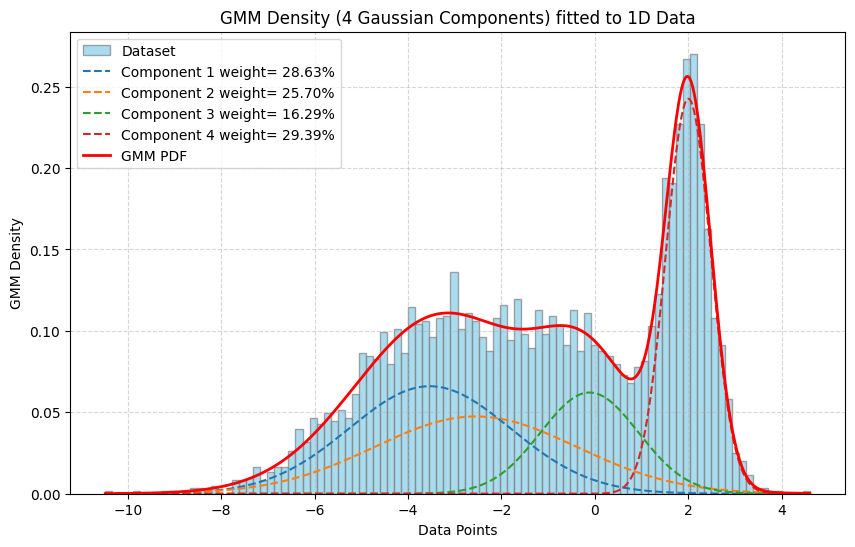

In [7]:
GMM.plot_GMM_1D(one_dimensional_example_X, gmm_em_lbg_1D)


## Constraining the eigenvalues of the covariance matrices
GMM estimation for more than 1 component using the ML approach is an **ill-posed** problem, because the GMM log-likelihood is not bounded above for $M \ge 2$. Indeed, we can have arbitrarily high log-likelihood by centering one component at one of the N samples, and letting the corresponding covariance matrix shrink towards zero. To avoid these kind of degenerate solutions, we can constrain the minimum values of the eigenvalues of the covariance matrices.

A possible solution consists in **constraining the eigenvalues of the covariance matrices to be larger or equal to a lower bound $\psi > 0$**. It's possible to show that the solution can be obtained by modifying the output of the M-step in the previous section. In particular, after we have computed $\Sigma_{g_{t+1}}$, we can compute its SVD:

$$U_g, S_g, U_g^T = \Sigma_{g_{t+1}}$$

where $S_g$ is a diagonal matrix of singular values, and replace the estimated covariance with

$$\Sigma_{g_{t+1}} = U_g S'_g U_g^T, \quad S'_{g_{ii}} = \max(\psi, S_{g_{ii}})$$

where $S'_{g_{ii}}$ is the $i$-th element of the diagonal of matrix $S'_g$.

In [8]:
#train GMM usinng EM+LBG and contrain eigenvalues of covariance matrices
X = np.load('../data/GMM_data_4D.npy')
gmm_contrained = GMM.train_GMM_EM_LBG(X, 4, psiEig=0.01)


Starting EM training [Run 4355]
Iter 10: LL = -7.556574, Delta = 0.00148616
Iter 20: LL = -7.545165, Delta = 0.00147682
Iter 30: LL = -7.503493, Delta = 0.00743704
Converged at Iter 39: LL = -7.478604, Delta = 0.00000020

Starting EM training [Run 4372]
Iter 10: LL = -7.326967, Delta = 0.00410245
Iter 20: LL = -7.265169, Delta = 0.00751177
Iter 30: LL = -7.254702, Delta = 0.00007784
Iter 40: LL = -7.253978, Delta = 0.00006426
Iter 50: LL = -7.253528, Delta = 0.00002768
Iter 60: LL = -7.253400, Delta = 0.00000499
Iter 70: LL = -7.253378, Delta = 0.00000099
Converged at Iter 70: LL = -7.253378, Delta = 0.00000099


# GMM for classification

GMMs can be used for classification in a similar way as we did for the MVG classifier. In particular,
we can train a GMM $GMM(\mathbf{M}_c,\mathbf{S}_c, w_c)$ for each class of thedataset, then model the class conditional distributions as GMM:
$$
f_{\mathbf{X} \mid C, \theta }(\mathbf{x} \mid c, \theta) \sim GMM(\mathbf{M}_c,\mathbf{S}_c, w_c)
$$
$$
f_{\mathbf{X} \mid C, \theta }(\mathbf{x} \mid c, \theta) = \sum_{k = 1}^{K_c} w_k \mathcal{N}(\mathbf{x} \mid \mu_{k, c}, \mathbf{\Sigma}_{k, c})
$$
Then we can compute the class posteriors using Bayes' rule:
$$
P(C = c \mid \mathbf{X} = \mathbf{x}) = \frac{P(C = c) \sum_{k = 1}^{K_c} w_k \mathcal{N}(\mathbf{x} \mid \mu_{k, c}, \mathbf{\Sigma}_{k, c})}{\sum_{c'} P(C = c') \sum_{k = 1}^{K_c} w_k \mathcal{N}(\mathbf{x} \mid \mu_{k, c'}, \mathbf{\Sigma}_{k, c'})}
$$
And, when solving multiclass problem, resort to the optimal Bayes decision for each class, whereas when resolving binary problems, compute the log posterior ratio.

In [9]:
from load_split import load_iris, split_db_2to1
from Bayes_decisions_Model_evaluation import computeEmpiricalBayesRisk_Normalized, computeMinEmpiricalBayesRisk_Normalized

In [10]:
D, L = load_iris()
print(f"Shape of D: {D.shape}, Shape of L: {L.shape}")

(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, L)
print(f"Shape of DTR: {DTR.shape}, Shape of LTR: {LTR.shape}")
print(f"Shape of DVAL: {DVAL.shape}, Shape of LVAL: {LVAL.shape}")

Shape of D: (4, 150), Shape of L: (150,)
Shape of DTR: (4, 100), Shape of LTR: (100,)
Shape of DVAL: (4, 50), Shape of LVAL: (50,)


In [11]:
#we try different number of components, so we can see how the GMM performs with different number of components

for k in [1, 2, 4, 8, 16]:
    #we model each one of the 3 classes with a GMM, so we have 3 GMMs
    gmm0, ll0 = GMM.train_GMM_EM_LBG(DTR[:, LTR == 0], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01, verbose=False)
    gmm1, ll1 = GMM.train_GMM_EM_LBG(DTR[:, LTR == 1], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01, verbose=False)
    gmm2, ll2 = GMM.train_GMM_EM_LBG(DTR[:, LTR == 2], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01, verbose=False)


    #we crate a score matrix of the 3 class conditional densities, which we model as GMMs
    SVAL = np.zeros((3, DVAL.shape[1]))  #score matrix of shape (3, N), where N is the number of validation samples
    #compute the score for each class
    SVAL[0, :] = GMM.logpdf_GMM(DVAL, gmm0)  #score for class 0
    SVAL[1, :] = GMM.logpdf_GMM(DVAL, gmm1)  #score for class 1
    SVAL[2, :] = GMM.logpdf_GMM(DVAL, gmm2)  #score for class 2

    #now compute log posterirs using Bayes' rule
    #we assume uniform priors, each one of 1/3
    priors = np.ones((3, DVAL.shape[1])) / 3.0

    log_posteriors = SVAL + np.log(priors)  #log posteriors of shape (3, N)

    #multiclass problem  -> choose optimal bayes decision, i.e. choose the class with the highest log posterior
    PVAL = np.argmax(log_posteriors, axis=0)  #predicted labels for the validation set


    #error rate
    error_rate = np.mean(PVAL != LVAL)  #error rate is the mean of the misclassified samples
    print(f"Number of components: {k}, Error rate: {error_rate * 100:.2f}%")

Number of components: 1, Error rate: 4.00%
Number of components: 2, Error rate: 4.00%
Number of components: 4, Error rate: 4.00%
Number of components: 8, Error rate: 4.00%
Number of components: 16, Error rate: 4.00%


As we already said, for binary tasks we can also compute the log posterior ratio $s(\mathbf{x}_t)$, from which we can derive the log likelihood ratio $\text{llr}(\mathbf{x}_t)$ and compare it with the prior log odds as threshold Then, we can compute the $\text{DCF}$ and $\text{min DCF}$ and see the goodness of the models and their misscalibration. We use an equivalent prior $\pi_T = 0.5$:

In [12]:
#load binary dataset
D, L = np.load('../data/ext_data_binary.npy'), np.load('../data/ext_data_binary_labels.npy')

print(f"Shape of D: {D.shape}, Shape of L: {L.shape}")

(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, L)
print(f"Shape of DTR: {DTR.shape}, Shape of LTR: {LTR.shape}")
print(f"Shape of DVAL: {DVAL.shape}, Shape of LVAL: {LVAL.shape}")

Shape of D: (4, 600), Shape of L: (600,)
Shape of DTR: (4, 400), Shape of LTR: (400,)
Shape of DVAL: (4, 200), Shape of LVAL: (200,)


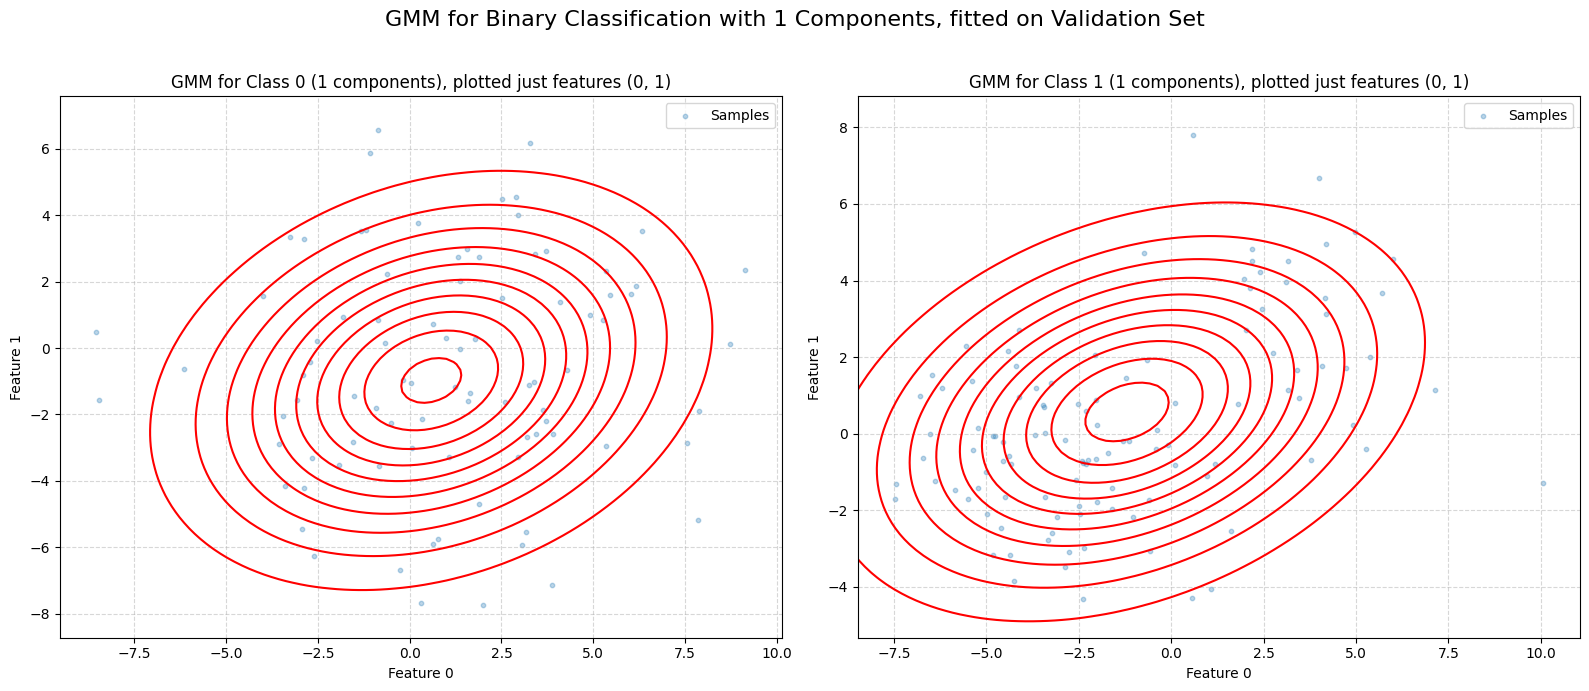

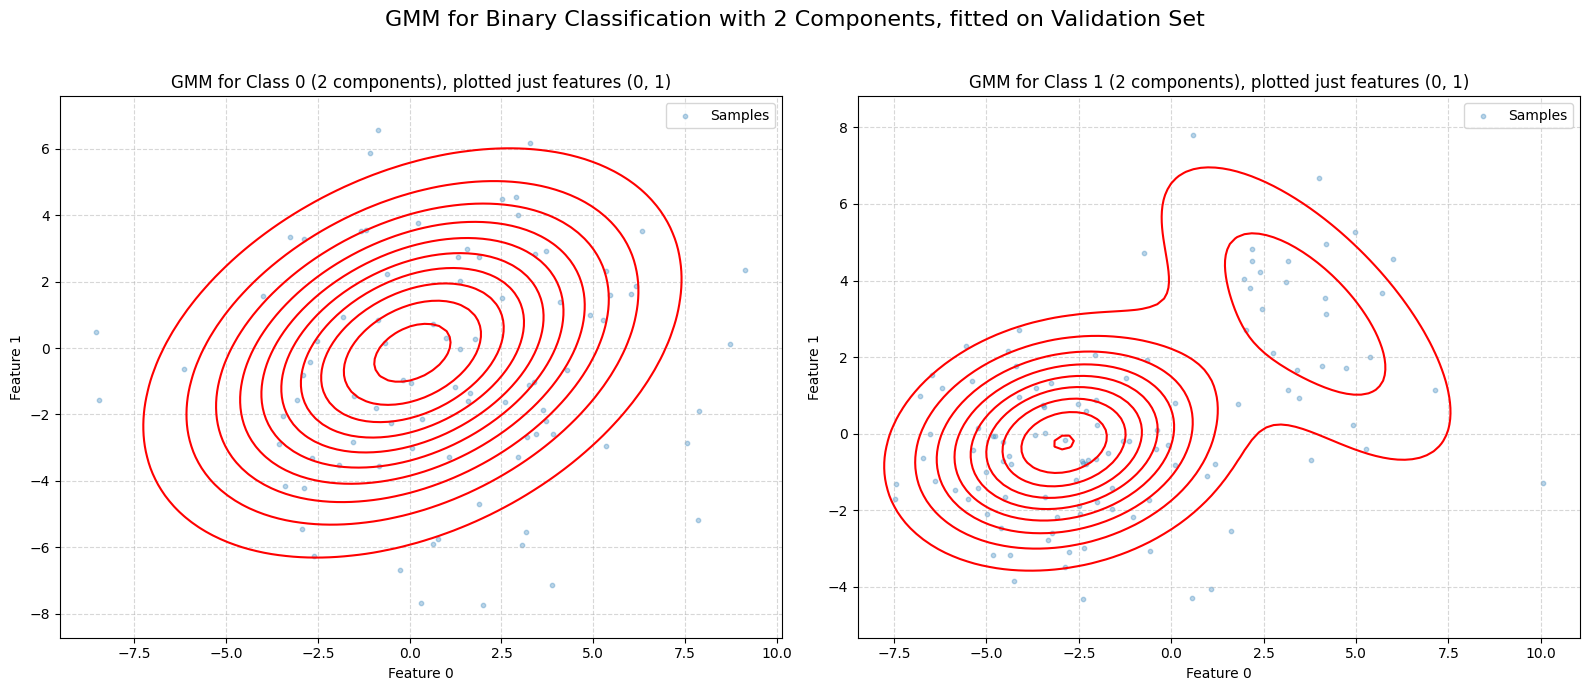

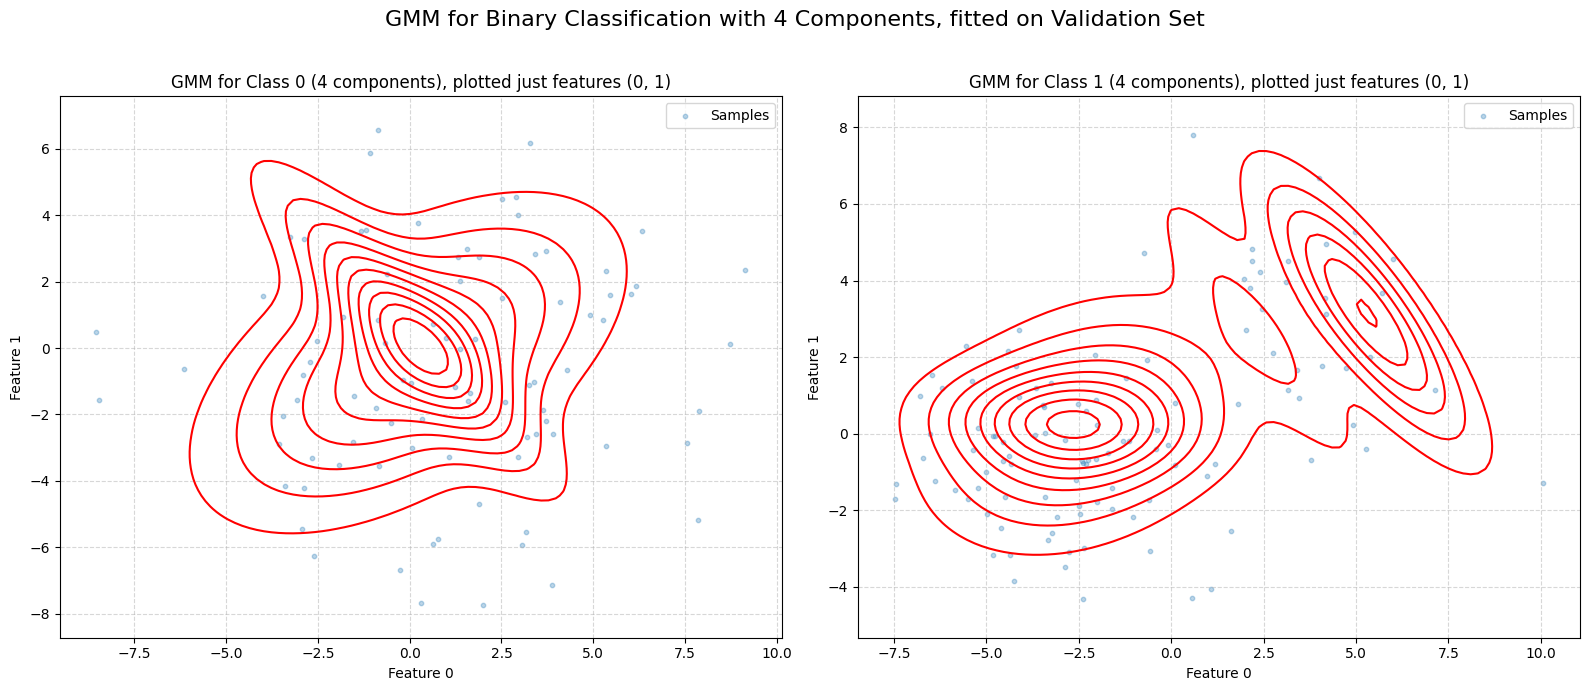

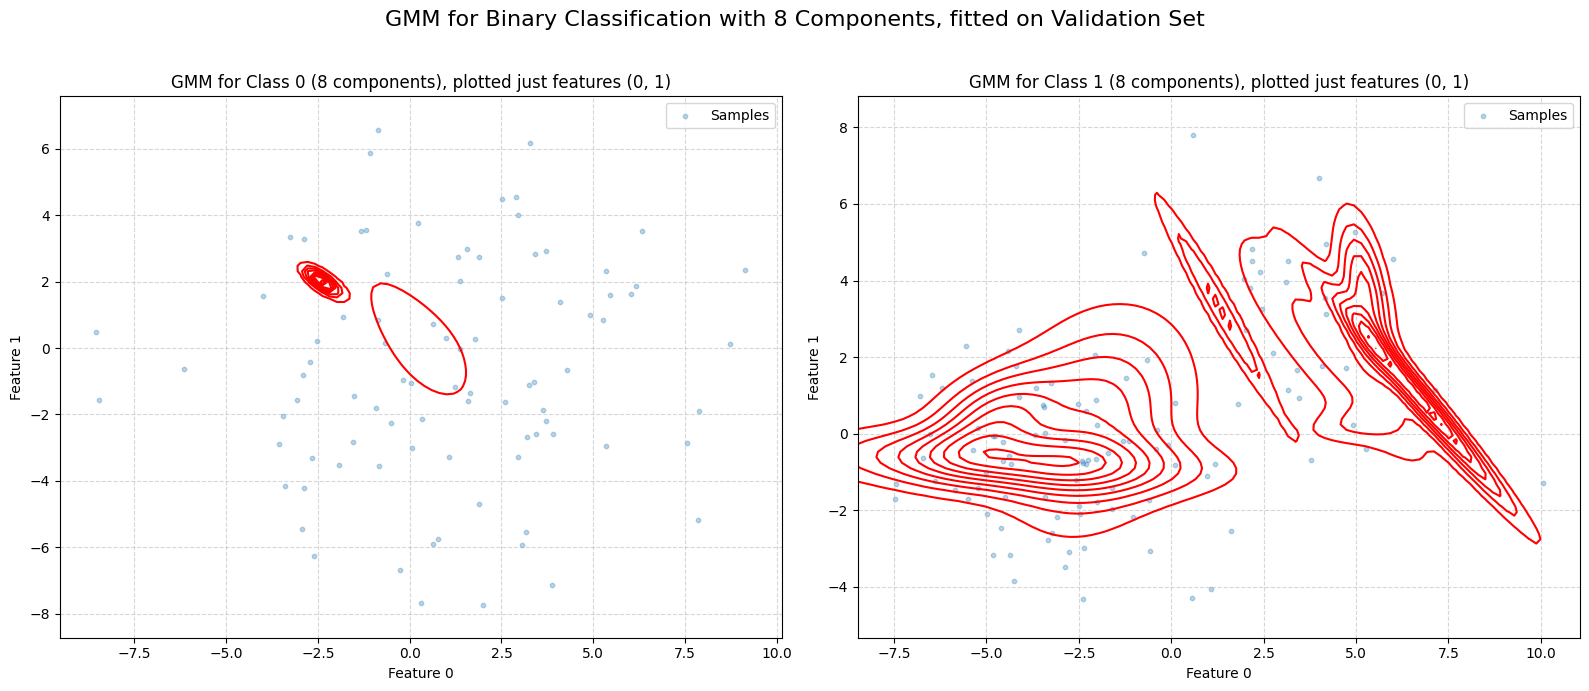

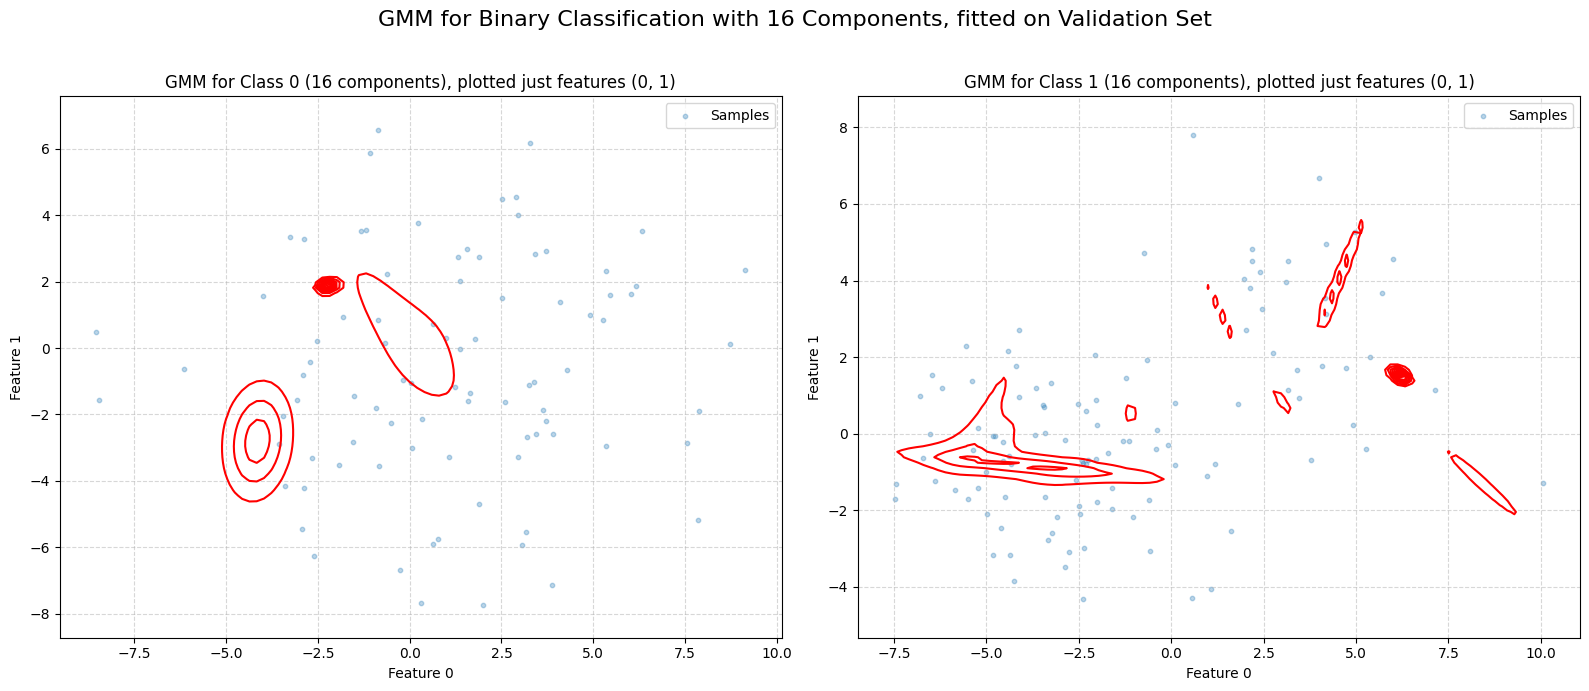

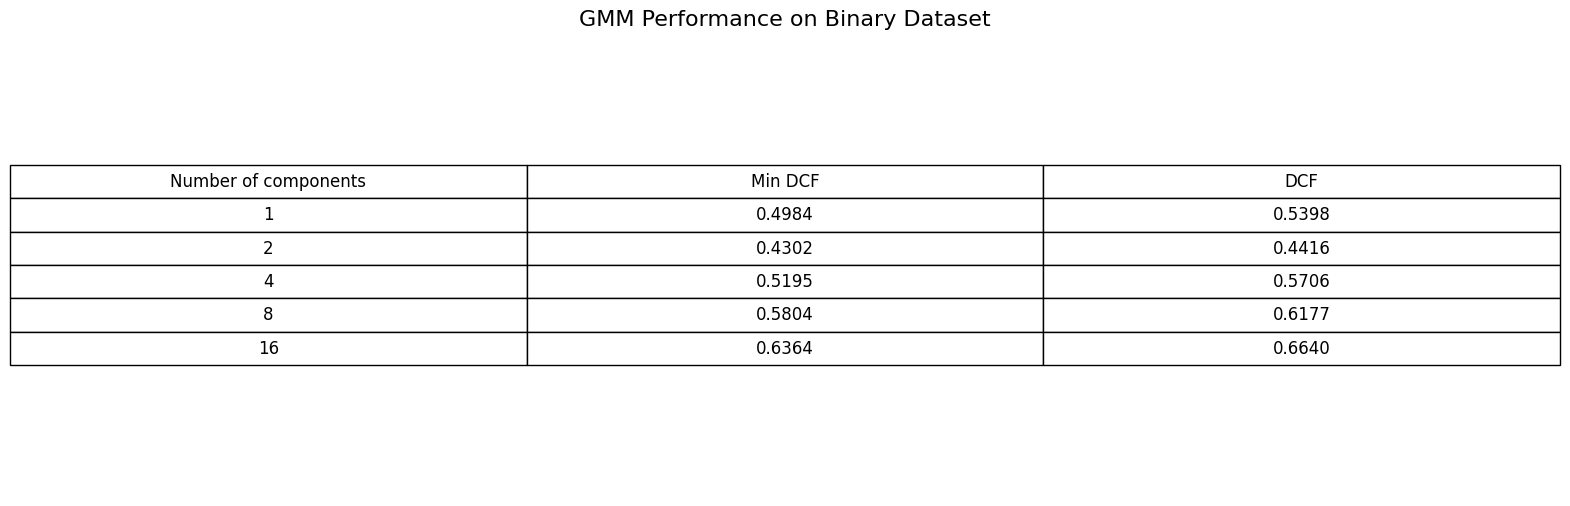

In [14]:
#as before, we try different number of components, so we can see how the GMM performs with different number of components
k_data = []
minDCFs = []
DCF_data = []

for k in [1, 2, 4, 8, 16]:
    #compute llr
    gmm0, ll0 = GMM.train_GMM_EM_LBG(DTR[:, LTR == 0], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01, verbose=False)
    gmm1, ll1 = GMM.train_GMM_EM_LBG(DTR[:, LTR == 1], targetNumberComponents=k, threshold_stop=1e-6, alpha=0.1, psiEig=0.01, verbose=False)

    GMM.plot_gmm_2d_classification(
         DVAL,
         LVAL,
         gmm0,
         gmm1,
         main_title=f"GMM for Binary Classification with {k} Components, fitted on Validation Set",
    )

    llr = GMM.logpdf_GMM(DVAL, gmm1) - GMM.logpdf_GMM(DVAL, gmm0)  #log likelihood ratio

    minDCF = computeMinEmpiricalBayesRisk_Normalized(llr, LVAL, 0.5, 1.0, 1.0)  #compute the normalized min DCF with a prior of 0.5
    DCF = computeEmpiricalBayesRisk_Normalized(llr, LVAL, 0.5, 1.0, 1.0)  #compute the normalized DCF with a prior of 0.5

    k_data.append(k)
    minDCFs.append(minDCF)
    DCF_data.append(DCF)


#plot in a table the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table_data = [["Number of components", "Min DCF", "DCF"]]
for k, minDCF, DCF in zip(k_data, minDCFs, DCF_data):
    table_data.append([k, f"{minDCF:.4f}", f"{DCF:.4f}"])

table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2, 2)
plt.title("GMM Performance on Binary Dataset", fontsize=16)
plt.show()